In [6]:
import pandas as pd
import numpy as np
from numpy import linalg as la
import random
import math as m
from decimal import Decimal  
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error as mse

Problem 2

In [7]:
ex = pd.read_csv("hw2-data/Bayes_classifier/X.csv", header = None)
why = pd.read_csv("hw2-data/Bayes_classifier/Y.csv", header = None)

In [8]:
def no_repeat_random(limit):
    larry = list(range(limit))
    lawrence = {}
    for i in range(limit):
        selected = random.choice(larry)
        lawrence[i] = selected
        larry.remove(selected)
    return lawrence

In [9]:
num_for_ex = no_repeat_random(len(ex))
for i in range(len(ex)):
    ex.loc[i, 'random_number'] = num_for_ex[i]

In [10]:
for i in range(len(ex)):
    if ex.loc[i, 'random_number'] <= ex.quantile(0.1)['random_number']:
        ex.loc[i, 'group'] = 1
    elif ex.loc[i, 'random_number'] <= ex.quantile(0.2)['random_number']:
        ex.loc[i, 'group'] = 2
    elif ex.loc[i, 'random_number'] <= ex.quantile(0.3)['random_number']:
        ex.loc[i, 'group'] = 3
    elif ex.loc[i, 'random_number'] <= ex.quantile(0.4)['random_number']:
        ex.loc[i, 'group'] = 4
    elif ex.loc[i, 'random_number'] <= ex.quantile(0.5)['random_number']:
        ex.loc[i, 'group'] = 5
    elif ex.loc[i, 'random_number'] <= ex.quantile(0.6)['random_number']:
        ex.loc[i, 'group'] = 6
    elif ex.loc[i, 'random_number'] <= ex.quantile(0.7)['random_number']:
        ex.loc[i, 'group'] = 7
    elif ex.loc[i, 'random_number'] <= ex.quantile(0.8)['random_number']:
        ex.loc[i, 'group'] = 8
    elif ex.loc[i, 'random_number'] <= ex.quantile(0.9)['random_number']:
        ex.loc[i, 'group'] = 9
    else:
        ex.loc[i, 'group'] = 10


In [11]:
ex = ex.drop(columns = ['random_number'])
why['group'] = ex['group']

In [12]:
def poisson(x_i, lam):
    prob = Decimal((lam ** x_i) * m.e **(-1 * lam))/(Decimal(m.factorial(x_i)))# * Decimal(m.e**(lam)))
    return Decimal(prob)

In [13]:
def to_max(x, y_i, n_1, n_0):
    lam = y_i * ((sum([y_i*x_i for x_i in x]) + 1)/(n_1 + 1)) + (1 - y_i) * ((sum([(1- y_i)*x_i for x_i in x]) + 1)/(n_0 + 1))
    return lam

In [14]:
final_results = [[0, 0], [0, 0]]
accuracies = []
lam_for_plot = {}

for group_larry in set(ex['group']):
    
    #FIRST NINE ARE FOR TRAINING
    prep_y = why[why['group'] != group_larry]
    prep_x = ex[ex['group'] != group_larry]
    
    #LAST ONE IS FOR TESTING
    test_y = why[why['group'] == group_larry]
    test_x = ex[ex['group'] == group_larry]
    
    #GETTING PARAMS FOR PREDICTIONS
    obs_1 = sum(prep_y[0])
    obs_0 = sum(1 - prep_y[0])
    
    pi = Decimal(obs_1/prep_y.shape[0])
    
    lambdas_1 = {}
    lambdas_0 = {}
    for x in prep_x:
        uptop_1_list = []
        uptop_2_list = []
        downlow_1_list = []
        downlow_2_list = []
        
        for y in prep_y.index:
            uptop_1 = prep_y.loc[y, 0] * prep_x.loc[y, x]
            uptop_1_list.append(uptop_1)
            
            uptop_2 = (1 - prep_y.loc[y, 0]) * prep_x.loc[y, x]
            uptop_2_list.append(uptop_2)
            
            downlow_1 = prep_y.loc[y, 0] + 1
            downlow_1_list.append(downlow_1)
            
            downlow_2 = (1 - prep_y.loc[y, 0]) + 1
            downlow_2_list.append(downlow_2)
            
        lam_1 = (sum(uptop_1_list)/(sum(downlow_1_list)))
        lam_0 = (sum(uptop_2_list)/(sum(downlow_2_list)))
    
        lambdas_1[x] = lam_1
        lambdas_0[x] = lam_0
        
        if group_larry == 1:
            lam_for_plot[x] = lam_1 + lam_0
        else:
            lam_for_plot[x] += lam_1 + lam_0
    
    #MAKING PREDICTIONS
    test_results = {}
    real = test_y[0]
    pred = []
    for i in test_y.index:
        indi = {}
        indi['actual'] = test_y.loc[i, 0]

        all_x_larries_1 = []
        all_x_larries_0 = []
        
        for x in test_x:
            
            x_cond_lam_1 = poisson(test_x.loc[i, x], lambdas_1[x])
            x_cond_lam_0 = poisson(test_x.loc[i, x], lambdas_0[x])
            all_x_larries_1.append(x_cond_lam_1)
            all_x_larries_0.append(x_cond_lam_0)
            

        eq_1 = pi * Decimal(np.prod(all_x_larries_1))
        eq_2 = (1 - pi) * Decimal(np.prod(all_x_larries_0))
        
        if eq_1 > eq_2:
            indi['predicted'] = 1
        else:
            indi['predicted'] = 0
        test_results[i] = indi
        pred.append(indi['predicted'])

    for i in test_results:
        if test_results[i]['actual'] == 0 and test_results[i]['predicted'] == 0:
            final_results[0][0] += 1
        elif test_results[i]['actual'] == 0 and test_results[i]['predicted'] == 1:
            final_results[0][1] += 1
        elif test_results[i]['actual'] == 1 and test_results[i]['predicted'] == 0:
            final_results[1][0] += 1
        if test_results[i]['actual'] == 1 and test_results[i]['predicted'] == 1:
            final_results[1][1] += 1
    
    accuracies.append(accuracy_score(real, pred))

In [15]:
(final_results[1][1] + final_results[0][0])/(final_results[1][1] + final_results[0][0] + final_results[0][1] + final_results[1][0])

0.8521739130434782

In [16]:
np.mean(accuracies)

0.8521739130434781

In [17]:
for lam in lam_for_plot:
    lam_for_plot[lam] = lam_for_plot[lam]/10

<ipython-input-18-32d64745c9fc>:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  plt.stem(lam_for_plot.values())


Text(0, 0.5, 'λ')

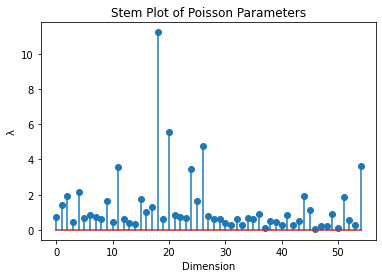

In [18]:
plt.stem(lam_for_plot.values())
plt.title("Stem Plot of Poisson Parameters")
plt.xlabel("Dimension")
plt.ylabel("λ")
#plt.savefig("poisson_stem")

In [19]:
lam_for_plot

{0: 0.7174245978400162,
 1: 1.3990039016212452,
 2: 1.9143526344958421,
 3: 0.4692904876219159,
 4: 2.1482331084858495,
 5: 0.6695318320917625,
 6: 0.8229264478840325,
 7: 0.7416113535954699,
 8: 0.6315092400027231,
 9: 1.6357914325677636,
 10: 0.4231321129055027,
 11: 3.5959920150663622,
 12: 0.6468912111099218,
 13: 0.4029507151545624,
 14: 0.35102023820550976,
 15: 1.7536520095178392,
 16: 0.9995569005471842,
 17: 1.2777461033145807,
 18: 11.216384462608994,
 19: 0.6138673175620237,
 20: 5.57522795240998,
 21: 0.8444489062837366,
 22: 0.7321327771026586,
 23: 0.6702683122542236,
 24: 3.4362567486845963,
 25: 1.6627539534006122,
 26: 4.786690823539557,
 27: 0.7878440834078653,
 28: 0.6180001268719213,
 29: 0.6455168620097129,
 30: 0.4058050088157281,
 31: 0.2949162976414866,
 32: 0.6153623109067854,
 33: 0.30026241399540937,
 34: 0.6618600378417587,
 35: 0.6221337441303939,
 36: 0.8752730211221056,
 37: 0.08434713964874008,
 38: 0.4962861304578922,
 39: 0.42186083963156634,
 40: 0.27

In [20]:
log_ex = ex.copy()
log_why = why.copy()

In [21]:
for i in log_why.index:
    if log_why.loc[i, 0] == 0:
        log_why.loc[i, 0] = -1

In [22]:
log_ex[54] = 1

In [23]:
def sigmoid(x):
    return np.exp(x)/(1 + np.exp(x))

In [24]:
def to_the(y, x, w):
    return y * np.dot(x, w)

In [25]:
def gradient(y, x, w):
    return np.dot((1 - sigmoid(to_the(y, x, w))), [y * x_i for x_i in x])


In [26]:
def obj_function(y, x, w):
    return np.log(sigmoid(to_the(y, x, w)))

In [27]:
st_asc_df = pd.DataFrame(columns = ['run', 'iteration', 'objective function'])
st_asc_dict = st_asc_df.to_dict()

In [28]:
step = 0.01/4600

w = []

for i in range(len(log_ex.drop(columns = 'group').T)):
    w.append(0)

In [29]:
counter = 0
st_asc = {}
for group_larry in set(log_ex['group']):
    log_why_prep_t = log_why[log_why['group'] != group_larry]
    log_ex_prep_t = log_ex[log_ex['group'] != group_larry]


    w = []

    for i in range(len(log_ex.drop(columns = 'group').T)):
        w.append(0)

    log_ex_prep_dict = log_ex_prep_t.drop(columns = 'group').T.to_dict()
    log_why_prep_dict = log_why_prep_t.drop(columns = 'group').T.to_dict()

    indi = {}
    for i in range(1001):
        
        grad_sum = []
        obj_sum = []

        for j in log_why_prep_dict.keys():
            y_i = log_why_prep_dict[j][0]
            x_i = list(log_ex_prep_dict[j].values())

            grad_sum.append(gradient(y_i, x_i, w))
            obj_sum.append(np.log(sigmoid(to_the(y_i, x_i, w))))

        indi[i] = sum(obj_sum)

        w = w + step * sum(grad_sum)
        counter += 1
        #print(counter)
    st_asc[group_larry] = indi

In [30]:
first_run = st_asc[1]
second_run = st_asc[2]
third_run = st_asc[3]
fourth_run = st_asc[4]
fifth_run = st_asc[5]
sixth_run = st_asc[6]
seventh_run = st_asc[7]
eighth_run = st_asc[8]
ninth_run = st_asc[9]
tenth_run = st_asc[10]


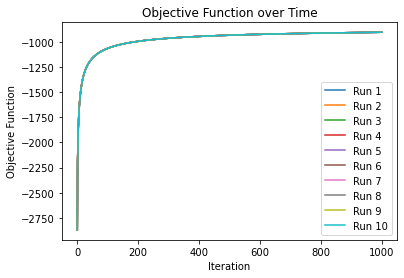

In [31]:
plt.plot(np.array(list(first_run.keys())), np.array(list(first_run.values())), label = "Run 1")
plt.plot(np.array(list(second_run.keys())), np.array(list(first_run.values())), label = "Run 2")
plt.plot(np.array(list(third_run.keys())), np.array(list(first_run.values())), label = "Run 3")
plt.plot(np.array(list(fourth_run.keys())), np.array(list(first_run.values())), label = "Run 4")
plt.plot(np.array(list(fifth_run.keys())), np.array(list(first_run.values())), label = "Run 5")
plt.plot(np.array(list(sixth_run.keys())), np.array(list(first_run.values())), label = "Run 6")
plt.plot(np.array(list(seventh_run.keys())), np.array(list(first_run.values())), label = "Run 7")
plt.plot(np.array(list(eighth_run.keys())), np.array(list(first_run.values())), label = "Run 8")
plt.plot(np.array(list(ninth_run.keys())), np.array(list(first_run.values())), label = "Run 9")
plt.plot(np.array(list(tenth_run.keys())), np.array(list(first_run.values())), label = "Run 10")
plt.title("Objective Function over Time")
plt.xlabel("Iteration")
plt.ylabel("Objective Function")
plt.legend()
#plt.savefig("log_reg_obj_funct")



In [42]:
def hess(y, x, w):
    first_half = np.dot(sigmoid(to_the(y, x, w)), (1 - sigmoid(to_the(y, x, w))))
    second_half = np.dot(x, x)
    return -np.dot(first_half, second_half)


In [43]:
counter = 0
new_meth = {}
for group_larry in set(log_ex['group']):
    log_why_prep_t = log_why[log_why['group'] != group_larry]
    log_ex_prep_t = log_ex[log_ex['group'] != group_larry]
    


    w = []

    for i in range(len(log_ex.drop(columns = 'group').T)):
        w.append(0)

    log_ex_prep_dict = log_ex_prep_t.drop(columns = 'group').T.to_dict()
    log_why_prep_dict = log_why_prep_t.drop(columns = 'group').T.to_dict()

    indi = {}
    for i in range(100):
        
        hessian = np.zeros((len(log_why), len(log_ex.drop(columns = ['group']).T)))
        grad_sum = []
        obj_sum = []
        hess_sum = []

        for j in log_why_prep_dict.keys():
            y_i = log_why_prep_dict[j][0]
            x_i = list(log_ex_prep_dict[j].values())
            


            grad_sum.append(gradient(y_i, x_i, w))
            obj_sum.append(np.log(sigmoid(to_the(y_i, x_i, w))))
            hess_sum.append(hess(y_i, x_i, w))
        indi[i] = sum(obj_sum)
        
        
        w = w - np.dot(sum(hessian), sum(grad_sum))
        counter += 1
        #print(counter)
    new_meth[group_larry] = indi

In [44]:
nm_first_run = new_meth[1]
nm_second_run = new_meth[2]
nm_third_run = new_meth[3]
nm_fourth_run = new_meth[4]
nm_fifth_run = new_meth[5]
nm_sixth_run = new_meth[6]
nm_seventh_run = new_meth[7]
nm_eighth_run = new_meth[8]
nm_ninth_run = new_meth[9]
nm_tenth_run = new_meth[10]


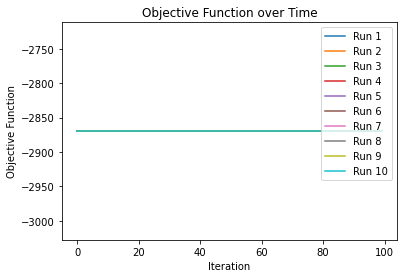

In [45]:
plt.plot(np.array(list(nm_first_run.keys())), np.array(list(nm_first_run.values())), label = "Run 1")
plt.plot(np.array(list(nm_second_run.keys())), np.array(list(nm_first_run.values())), label = "Run 2")
plt.plot(np.array(list(nm_third_run.keys())), np.array(list(nm_first_run.values())), label = "Run 3")
plt.plot(np.array(list(nm_fourth_run.keys())), np.array(list(nm_first_run.values())), label = "Run 4")
plt.plot(np.array(list(nm_fifth_run.keys())), np.array(list(nm_first_run.values())), label = "Run 5")
plt.plot(np.array(list(nm_sixth_run.keys())), np.array(list(nm_first_run.values())), label = "Run 6")
plt.plot(np.array(list(nm_seventh_run.keys())), np.array(list(nm_first_run.values())), label = "Run 7")
plt.plot(np.array(list(nm_eighth_run.keys())), np.array(list(nm_first_run.values())), label = "Run 8")
plt.plot(np.array(list(nm_ninth_run.keys())), np.array(list(nm_first_run.values())), label = "Run 9")
plt.plot(np.array(list(nm_tenth_run.keys())), np.array(list(nm_first_run.values())), label = "Run 10")
plt.title("Objective Function over Time")
plt.xlabel("Iteration")
plt.ylabel("Objective Function")
plt.legend()

Problem 3 

In [32]:
ex_train = pd.read_csv("hw2-data/Gaussian_process/X_train.csv", header = None)
why_train = pd.read_csv("hw2-data/Gaussian_process/y_train.csv", header = None)

ex_test = pd.read_csv("hw2-data/Gaussian_process/X_test.csv", header = None)
why_test = pd.read_csv("hw2-data/Gaussian_process/y_test.csv", header = None)

In [33]:
def kern(x_1, x_2, b):
    top_base = np.subtract(x_1, x_2)
    numerator = np.dot(top_base, top_base)
    denom = -1 * b
    to_the = numerator/denom
    final = m.e ** to_the
    return final

In [34]:
def build_k_n(x, b):
    
    k_n = [[0 for i in range(len(x))] for j in range(len(x))]

    for i in range(len(x)):
        for j in range(len(x)):
            k_n[i][j] = kern(x.loc[i], x.loc[j], b)
    return k_n

In [35]:
def build_k_new(known_x, new_x, b):
    
    k_new = []
    
    for i in range(len(known_x)):
        k_new.append(kern(new_x, known_x.loc[i], b))
        
    return k_new

In [36]:
def find_mean(known_x, new_x, sig_sq, kernel_known, kernel_new, y):
    
    k_n = kernel_known
    
    k_new = kernel_new
    
    first_part = k_new #kern(new_x, known_x, b)
    
    ident = sig_sq * np.identity(len(k_n))
    second_part = np.add(ident, k_n)
    second_part = la.inv(second_part)
    
    combined = np.dot(first_part, second_part)
    
    final = np.dot(combined, y)[0]
    return final

In [37]:
sig_b_mse = pd.DataFrame(columns = ['Sigma Squared', 'b', 'RMSE'])

counter = 0

for b in (5,7,9,11,13,15):
    first_k_n = build_k_n(ex_train, b)
    
    for sig_squared in (.1,.2,.3,.4,.5,.6,.7,.8,.9,1):
        
        sig_b_mse.loc[counter, 'Sigma Squared'] = sig_squared
        sig_b_mse.loc[counter, 'b'] = b
        
        preds = []
        
        for i in why_test.index:
            
            x_vect = ex_test.loc[i]

            pred = find_mean(ex_train, x_vect, sig_squared, first_k_n, build_k_new(ex_train, x_vect, 7), why_train)
            preds.append(pred)
            
        rmse = mse(why_test, preds, squared = False)
        sig_b_mse.loc[counter, 'RMSE'] = rmse
        
        counter += 1

In [38]:
sig_b_mse1 = sig_b_mse
sig_b_mse1['RMSE'] = sig_b_mse1['RMSE'].apply(lambda x: round(x,4))
letsc = sig_b_mse1.pivot(index = 'Sigma Squared', columns = 'b', values = 'RMSE')

#letsc.to_csv("prob_3_a_table.csv")

In [39]:
d4_y_df = pd.DataFrame(columns = ['d4', 'y', 'pred'])

counter = 0


first_k_n = build_k_n(ex_train, 5)
    

preds = []

for i in why_test.index:

    x_vect = ex_test.loc[i, 3]
    
    d4_y_df.loc[counter, 'd4'] = ex_test.loc[i, 3]
    d4_y_df.loc[counter, 'y'] = why_test.loc[i, 0]

    pred = find_mean(ex_train[3], x_vect, sig_squared, first_k_n, build_k_new(ex_train[3], x_vect, 7), why_train)
    
    d4_y_df.loc[counter, 'pred'] = pred
    counter +=1

    

   

Text(0, 0.5, 'Y')

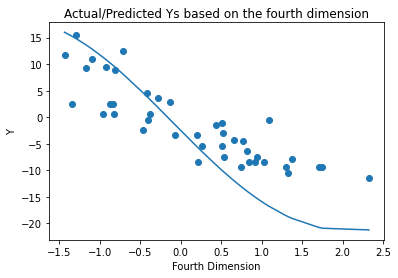

In [40]:
plt.scatter(d4_y_df['d4'], d4_y_df['y'])
plt.plot(d4_y_df.sort_values(by = 'd4')['d4'], d4_y_df.sort_values(by = 'd4')['pred'])
plt.title("Actual/Predicted Ys based on the fourth dimension")
plt.xlabel("Fourth Dimension")
plt.ylabel("Y")
#plt.savefig("d4_vs_y")